This script is aimed to look at various ways of separating specular reflection and body reflection from an image

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('five_apples.jpg')  # Replace 'image.jpg' with your file
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

GrayScale Intensity Threshold
- Convert the image to a grayscale intensity map.
- Identify specular highlights using a threshold on intensity.

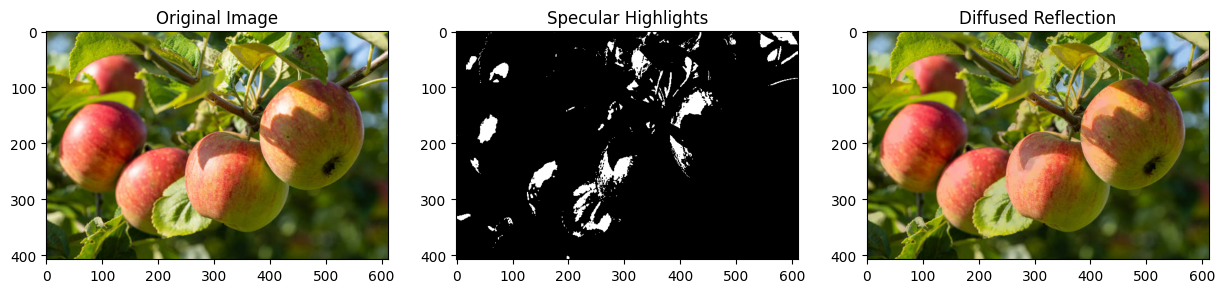

In [11]:
# Convert to grayscale for intensity analysis
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Specular mask using intensity threshold
_, specular_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Diffused reflection (subtract specular)
diffused_reflection = cv2.inpaint(image_rgb, specular_mask, 3, cv2.INPAINT_TELEA)

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image_rgb); plt.title('Original Image')
plt.subplot(1, 3, 2); plt.imshow(specular_mask, cmap='gray'); plt.title('Specular Highlights')
plt.subplot(1, 3, 3); plt.imshow(diffused_reflection); plt.title('Diffused Reflection')
plt.show()


Polarization Based method requires actual images taken from polarized camera, so skipping for now until an alternative is found.

Gradient Analysis
- Compute the gradient of the image to locate sharp intensity changes (specular highlights).
- Treat areas with low gradients as diffuse reflection.

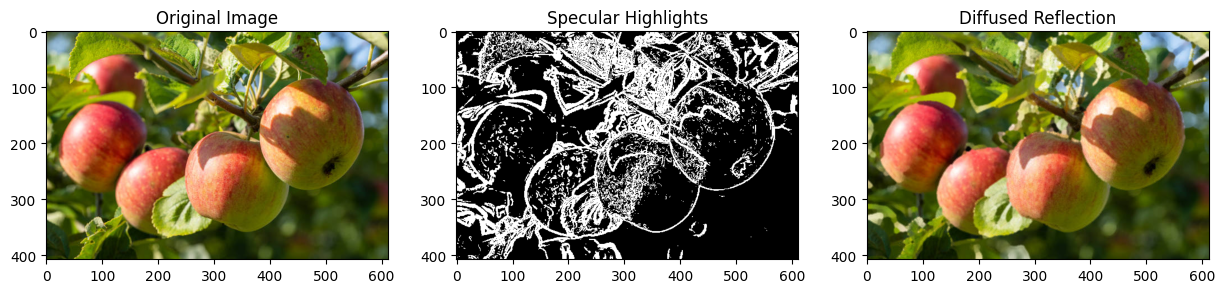

In [12]:
# Compute gradients
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

# Threshold for specular highlights
_, specular_mask = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)

# Diffused reflection
diffused_reflection = cv2.inpaint(image_rgb, specular_mask.astype(np.uint8), 3, cv2.INPAINT_TELEA)

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(image_rgb); plt.title('Original Image')
plt.subplot(1, 3, 2); plt.imshow(specular_mask, cmap='gray'); plt.title('Specular Highlights')
plt.subplot(1, 3, 3); plt.imshow(diffused_reflection); plt.title('Diffused Reflection')
plt.show()

Retinex-Based

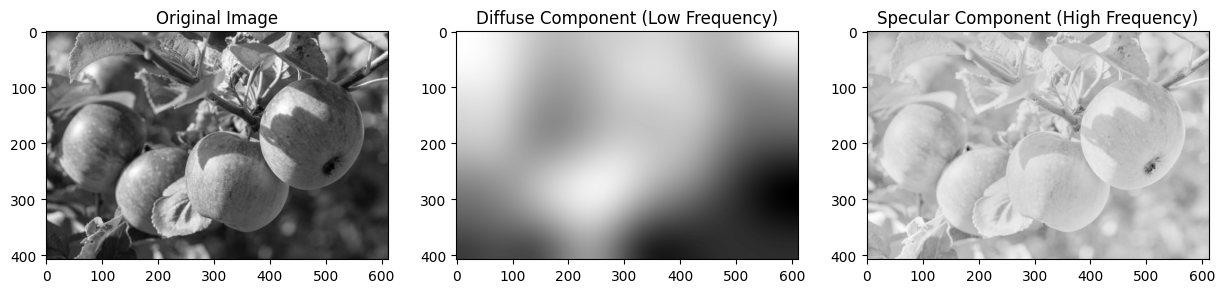

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def separate_specular_diffuse(image, sigma=50):
    """
    Separates specular and diffuse reflections using Retinex-based processing.
    
    Parameters:
    - image: Input grayscale image (2D array).
    - sigma: Standard deviation for Gaussian blur (controls low-frequency illumination).
    
    Returns:
    - diffuse: The diffused reflection (low-frequency component).
    - specular: The specular reflection (high-frequency component).
    """
    log_image = np.log1p(image.astype(np.float32))  # Log transformation
    illumination = cv2.GaussianBlur(log_image, (0, 0), sigma)  # Low-frequency illumination
    specular = log_image - illumination  # High-frequency (specular reflection)
    # Normalize components for display
    diffuse = cv2.normalize(illumination, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    specular = cv2.normalize(specular, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return diffuse, specular

# Apply the separation
diffuse, specular = separate_specular_diffuse(gray)

# Plot the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(gray, cmap='gray'); plt.title('Original Image')
plt.subplot(1, 3, 2); plt.imshow(diffuse, cmap='gray'); plt.title('Diffuse Component (Low Frequency)')
plt.subplot(1, 3, 3); plt.imshow(specular, cmap='gray'); plt.title('Specular Component (High Frequency)')
plt.show()


HSV based separation

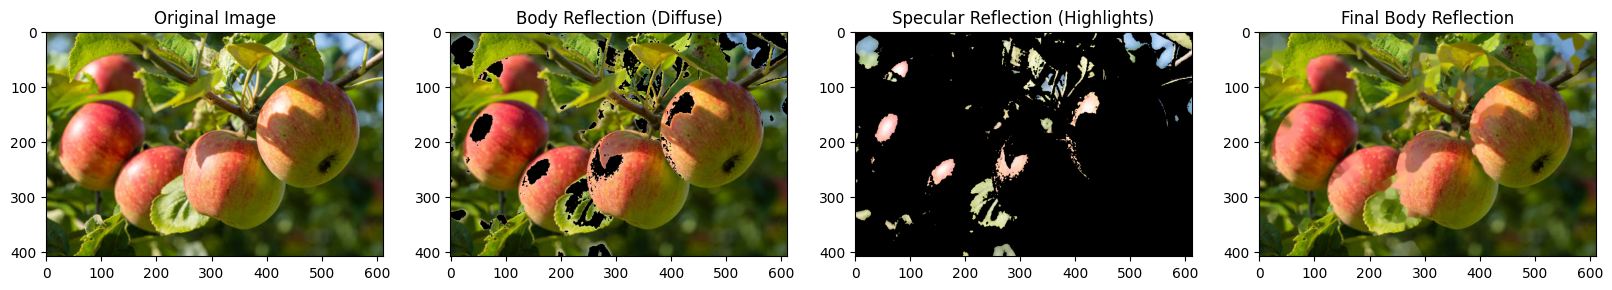

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def separate_specular_body_hsv(image, intensity_threshold=200, saturation_threshold=50):
    """
    Separate specular and body reflection using HSV color space.

    Parameters:
    - image: Input color image (BGR format).
    - intensity_threshold: Threshold for the Value channel to identify specular highlights.
    - saturation_threshold: Threshold for the Saturation channel to distinguish low-saturation specular highlights.

    Returns:
    - body_reflection: Image with body reflection (diffused).
    - specular_reflection: Image with specular reflection (highlights).
    - final_body_reflection: Body reflection image with specular highlights removed.
    """
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    # Create masks for specular and diffuse components
    # specular_mask = (v > intensity_threshold) & (s < saturation_threshold)
    specular_mask1 = (v > 200) & (s < 50)
    specular_mask2 = (v > 150) & (s < 100)
    specular_mask = specular_mask1 | specular_mask2

    
    # Generate specular and body reflection images
    specular_reflection = image.copy()
    specular_reflection[~specular_mask] = 0  # Mask out non-specular areas
    
    body_reflection = image.copy()
    body_reflection[specular_mask] = 0  # Mask out specular areas

    # Remove specular component from body reflection using inpainting
    specular_mask = specular_mask.astype(np.uint8) * 255  # Convert mask to binary for inpainting
    # final_body_reflection = cv2.inpaint(body_reflection, specular_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    dilated_mask = cv2.dilate(specular_mask.astype(np.uint8), kernel, iterations=1)
    final_body_reflection = cv2.inpaint(body_reflection, dilated_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # for _ in range(100):  # Iteratively refine
    #     specular_mask = (v > intensity_threshold) & (s < saturation_threshold)
    #     specular_mask = specular_mask.astype(np.uint8) * 255
    #     final_body_reflection = cv2.inpaint(body_reflection, specular_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    
    return body_reflection, specular_reflection, final_body_reflection

# Apply the separation and specular removal
body_reflection, specular_reflection, final_body_reflection = separate_specular_body_hsv(image)

# Convert images to RGB for display
body_reflection_rgb = cv2.cvtColor(body_reflection, cv2.COLOR_BGR2RGB)
specular_reflection_rgb = cv2.cvtColor(specular_reflection, cv2.COLOR_BGR2RGB)
final_body_reflection_rgb = cv2.cvtColor(final_body_reflection, cv2.COLOR_BGR2RGB)

# Plot the results
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1); plt.imshow(image_rgb); plt.title('Original Image')
plt.subplot(1, 4, 2); plt.imshow(body_reflection_rgb); plt.title('Body Reflection (Diffuse)')
plt.subplot(1, 4, 3); plt.imshow(specular_reflection_rgb); plt.title('Specular Reflection (Highlights)')
plt.subplot(1, 4, 4); plt.imshow(final_body_reflection_rgb); plt.title('Final Body Reflection')
plt.show()